In [ ]:
from google.colab import drive #mounted my google drive folder onto my Juypter notebook
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%pip install biopython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 85.1 MB/s eta 0:00:00


In [ ]:
from Bio import SeqIO
import re
import csv
import math
import random
import gzip
import torch
from sklearn import metrics
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import os 
import pickle
import warnings

# Part 1

## Project Introduction

In the project we analyzed ChIP-seq data for Condensin in yeast. We want to find the motifs that are related to binding condensin (a protein) within some sequences in yeast. To do this we had to identify condensin peaks (when condensin is the most highly active in the cell). ChIP-seq did this by using an antibody against a condensin subunit. Cells are crosslinked with formaldehyde for protein-DNA interaction stabilization and then fragmented into smaller pieces. These pieces containing the condensin subunit are then immunoprecipated using an antibody against the subunit of interest. These fragments are then sequenced and the reads are mapped to the reference genome to generate a genome-wide map of condensin occupancy. 

This data was collected from both Log (active) and Quiescent (dormant) cells. 

In this initial set of files, we were provided ChIP-seq peaks (called by MACS2) in both the log and quiescent cell state.

For the ChIP-seq peak calls, there are files in two formats, .narrowPeak and .bed. The .bed is much more straightforward but the .narrowPeak gives more information about the location of the entire peak (not just the summit of the peak, but also the length). \

For .narrowPeak, the columns are: 
chromosome #, chromosome start position, chromosome end position, name, score, strand (not included in our data), enrichment value, p value, q value, peak (the distance of peak summit from chromosome start).\

For .bed, the columns are:\
chromosome #, chromosome start position of peak summit, chromosome end position of peak summit, name, p value.\

In the project we analyzed ChIP-seq data for Condensin in yeast. We want to find the motifs that are related to binding condensin (a protein) within some sequences in yeast. To do this we had to identify condensin peaks (when condensin is the most highly active in the cell). ChIP-seq did this by using an antibody against a condensin subunit. Cells are crosslinked with formaldehyde for protein-DNA interaction stabilization and then fragmented into smaller pieces. These pieces containing the condensin subunit are then immunoprecipated using an antibody against the subunit of interest. These fragments are then sequenced and the reads are mapped to the reference genome to generate a genome-wide map of condensin occupancy. 

This data was collected from both Log (active) and Quiescent (dormant) cells. 

In this initial set of files, we were provided ChIP-seq peaks (called by MACS2) in both the log and quiescent cell state.

For the ChIP-seq peak calls, there are files in two formats, .narrowPeak and .bed. The .bed is much more straightforward but the .narrowPeak gives more information about the location of the entire peak (not just the summit of the peak, but also the length). \

For .narrowPeak, the columns are: 
chromosome #, chromosome start position, chromosome end position, name, score, strand (not included in our data), enrichment value, p value, q value, peak (the distance of peak summit from chromosome start).\

For .bed, the columns are:\
chromosome #, chromosome start position of peak summit, chromosome end position of peak summit, name, p value.\

### Creating a dictionary mapping and getting the location

In [ ]:
#get loc2 will create a dictionary mapping the location to the reference number
#This is okay for our example as the locations are unique,
#but will not work if there are common locations for different reference numbers
def getloc2ref(record_dict):
    regex_dict={"ref":re.compile(r"ref\|.+\|"),
                "chr":re.compile(r"\[chromosome=([A-Z]+)\]"),
               "mito":re.compile(r"\[location=mitochondrion\]")}
    record_key_dict={}
    f = open(inputfile, "r")
    for record in record_dict:
        line=record_dict[record].description
        refobj=re.search(regex_dict["ref"],line)
        chrobj=re.search(regex_dict["chr"],line)
        mitoobj=re.search(regex_dict["mito"],line)
        if chrobj:
            record_key_dict[chrobj.group(1)]=refobj.group(0)
        elif mitoobj:
#            print("mito")
            record_key_dict["mito"]=refobj.group(0)
    #print(record_key_dict)
    return record_key_dict

#https://genome.ucsc.edu/FAQ/FAQformat.html#format1
#the bed file has chromosome name, starting position(indexed from 0), ending position and other things.
#For a complete list, see the link above.
# getpeakseqs gets the location,start and end points of the peaks from the peakinput file and grabs the corresponding 
#sequence from record_dict. We need a record_key_dict since the location data is not in the key.
#asstr=False will maintain the SeqIO seq datatype for the sequences which may be useful in the future.
#For now, default is to make them strings

#IMPORTANT NOTE: I could not find which file contains the "pombeIII" location. So those peaks are not considered as I dont know 
#where to get the sequences from
def getpeakseqs(peakinputfile,record_dict,record_key_dict,asstr=True, loc=False):
    peaks=[]
    f = open(peakinputfile, "r")
    for line in f:
        words=line.split()
        loc=words[0]
        if loc in record_key_dict.keys():
            start=int(words[1])
            stop=int(words[2])
        #    print(loc,start,stop)
        #    print(record_key_dict[loc])
        #    print(record_dict[record_key_dict[loc]].description)
            if asstr:
                if loc:
                    peaks.append((loc, start, str(record_dict[record_key_dict[loc]].seq[start:stop+1])))
                else:
                    peaks.append(str(record_dict[record_key_dict[loc]].seq[start:stop+1]))
            else:
                peaks.append(record_dict[record_key_dict[loc]].seq[start:stop+1])
    f.close()
    return peaks





### Reading in the input file and the record dictionary


- We also read in the peaks which are regions of the genome that have been identified as having a higher level of enrichment for Condensin binding compared to the rest of the genome. 
- peaks Q are the peaks in the quiescent cells. 
- peaks L are the log peaks of the quiescent cells. 

In [ ]:
#Setting up location
os.chdir('/content/drive/MyDrive/Rerunningbioproj/Final_project_folder')

In [ ]:
inputfile="S288C_reference_sequence_R64-3-1_20210421.fsa"
record_dict = SeqIO.to_dict(SeqIO.parse(inputfile, "fasta"))

print("keys for the record_dict which stores the sequences for the whole genome")
print(record_dict.keys())
#The keys only show reference number but 
#donot show which chromosome the sequence is on.
#We need this data, for the peaks.

record_key_dict=getloc2ref(record_dict)
print("record_key_dict")
print(record_key_dict)

peakinputfile_Q="Condensin_peaks_quiescence.narrowPeak"
peakinputfile_L="Condensin_peaks_Log.narrowPeak"

peaks_Q=getpeakseqs(peakinputfile_Q,record_dict,record_key_dict) #size: 1000
peaks_L=getpeakseqs(peakinputfile_L,record_dict,record_key_dict) #size: 1000

print(f"Number of peaks for Q is {len(peaks_Q)}")
print(f"Number of peaks for Log is {len(peaks_L)}")
print("NOTE that the pombeIII peaks are missing as the seq data could not be found")


keys for the record_dict which stores the sequences for the whole genome
dict_keys(['ref|NC_001133|', 'ref|NC_001134|', 'ref|NC_001135|', 'ref|NC_001136|', 'ref|NC_001137|', 'ref|NC_001138|', 'ref|NC_001139|', 'ref|NC_001140|', 'ref|NC_001141|', 'ref|NC_001142|', 'ref|NC_001143|', 'ref|NC_001144|', 'ref|NC_001145|', 'ref|NC_001146|', 'ref|NC_001147|', 'ref|NC_001148|', 'ref|NC_001224|'])
record_key_dict
{'I': 'ref|NC_001133|', 'II': 'ref|NC_001134|', 'III': 'ref|NC_001135|', 'IV': 'ref|NC_001136|', 'V': 'ref|NC_001137|', 'VI': 'ref|NC_001138|', 'VII': 'ref|NC_001139|', 'VIII': 'ref|NC_001140|', 'IX': 'ref|NC_001141|', 'X': 'ref|NC_001142|', 'XI': 'ref|NC_001143|', 'XII': 'ref|NC_001144|', 'XIII': 'ref|NC_001145|', 'XIV': 'ref|NC_001146|', 'XV': 'ref|NC_001147|', 'XVI': 'ref|NC_001148|', 'mito': 'ref|NC_001224|'}
Number of peaks for Q is 1591
Number of peaks for Log is 936
NOTE that the pombeIII peaks are missing as the seq data could not be found


In [ ]:
#:FOR THE CURIOUS: Get methods
def get_methods(object, spacing=20):
  methodList = []
  for method_name in dir(object):
    try:
        if callable(getattr(object, method_name)):
            methodList.append(str(method_name))
    except Exception:
        methodList.append(str(method_name))
  processFunc = (lambda s: ' '.join(s.split())) or (lambda s: s)
  for method in methodList:
    try:
        print(str(method.ljust(spacing)) + ' ' +
              processFunc(str(getattr(object, method).__doc__)[0:90]))
    except Exception:
        print(method.ljust(spacing) + ' ' + ' getattr() failed')
        
#For the curious, the sequence object has the following attributes. 
#Thus it might be beneficial to store as this datatype sometime (use asstr=False in getpeakseqs) 
loc="I"

### Convolutional Neural Network

In [ ]:
class MultiLayer(nn.Module):
    def __init__(self, num_motif, motif_len,
                 sigma_conv, sigma_w, dropout = False, dropout_rate = 0.2):
      
        super(MultiLayer, self).__init__()
        self.sigma_conv=sigma_conv
        self.sigma_w=sigma_w
        self.input_channels=4
        self.activation = nn.ReLU()
        self.FC_size=64
        self.conv1 = nn.Sequential(nn.Conv1d(in_channels=self.input_channels,
                                             out_channels=num_motif,
                                             kernel_size=motif_len),
                                   nn.ReLU(),
                                   nn.MaxPool1d(kernel_size=2))
                                   
        self.conv2 = nn.Sequential(nn.Conv1d(in_channels=50,
                                             out_channels=64,
                                             kernel_size=motif_len),
                                   nn.ReLU(),
                                   nn.MaxPool1d(kernel_size=2))
        
        self.conv3 = nn.Sequential(nn.Conv1d(in_channels=64,
                                             out_channels=64,
                                             kernel_size=motif_len),
                                   nn.ReLU(),
                                   nn.MaxPool1d(kernel_size=2))
        
        
        self.conv1[0].weight.requires_grad=True
        self.conv1[0].bias.requires_grad=True

        self.conv2[0].weight.requires_grad=True
        self.conv2[0].bias.requires_grad=True

        self.conv3[0].weight.requires_grad=True
        self.conv3[0].bias.requires_grad=True
        
        self.w=torch.randn(self.FC_size,1).to(device)
        self.b=torch.randn(1).to(device)
        torch.nn.init.normal_(self.w,mean=0,
                              std=self.sigma_w)
        torch.nn.init.normal_(self.b,mean=0,
                              std=self.sigma_w)
        self.w.requires_grad=True
        self.b.requires_grad=True
        self.dropout = nn.Dropout(p=dropout_rate)

                
    def get_weights(self):
        return [self.conv1[0].weight, self.conv1[0].bias, self.conv2[0].weight, self.conv2[0].bias,
                self.conv3[0].weight, self.conv3[0].bias, model.w, model.b]
        
    def forward(self, x):
        
        x=self.conv1(x)
        if self.dropout:
            x = self.dropout(x)
        x=self.conv2(x)
        if self.dropout:
            x = self.dropout(x)
        x=self.conv3(x)
        if self.dropout:
            x = self.dropout(x)
        # activation
        x=self.activation(x)
        # max pooling
        x,_ = torch.max(x, dim=2)
        # fully connected layer
        x=x@self.w + self.b
        x=self.dropout(x)
        return torch.sigmoid(x)
    

## Setting parameters, padding, and other functions

### Padded version of sequence in the form of a numpy array:

In [ ]:
def seqtopad(sequence, motif_len):
    rows=len(sequence) + 25 + motif_len
    #print(len(sequence))
    S=np.empty([rows,4])
    base=['A', 'C', 'G', 'T']
    for i in range(rows):
        for j in range(4):
            if (i < 25 or i > len(sequence) + 23):
                S[i,j]=np.float32(0.25)
            elif sequence[i - 25] == 'N':
                S[i,j]=np.float32(0.25)
            elif (i > 25 and sequence[i - 24]==base[j]):
                S[i,j]=np.float32(1)
            else:
                S[i,j]=np.float32(0)
    return np.transpose(S)

### Creating a dataset which returns the train, valid, dataset, sequences, and the valid sequences

In [ ]:
def create_dataset(inp):
    train_dataset=[]
    sequences=[]
    max_length = max([len(i) for i in inp])
    for i in range(len(inp)):
        if(len(inp[i]) < 1000): 
            padding_size = 1000 - len(inp[i])
            shuffled = list(inp[i])
            random.shuffle(shuffled)
            shuffled = "".join(shuffled)
            position_matrix = seqtopad(inp[i], padding_size)
            sequences.append(position_matrix)
            train_dataset.append([position_matrix, [1]])
            shuffled_position_matrix = seqtopad(shuffled, padding_size)
            sequences.append(shuffled_position_matrix)
            train_dataset.append([shuffled_position_matrix, [0]])
    random.shuffle(train_dataset)
    size=int(len(train_dataset)/5)
    print(len(train_dataset))
    firsttrain=train_dataset[:4*size]
    firstvalid=train_dataset[4*size+1:]
    validseq = sequences[4*size+1:]
    return firsttrain,firstvalid,train_dataset,sequences,validseq

### Loading and preprocessing the data for training a machine learning model. 

In [ ]:
class chipseq_dataset(Dataset):
    def __init__(self, xy=None):
        self.x_data = np.asarray([el[0] for el in xy],dtype=np.float32)
        self.y_data = np.asarray([el[1] for el in xy],dtype=np.float32)
        self.x_data = torch.from_numpy(self.x_data)
        self.y_data = torch.from_numpy(self.y_data)
        self.length=len(self.x_data)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.length

## Training the Network

The below code is the actual training. We originally trained three different data sets and we used a motif size of 10. We also have networks trained elsewhere on motif lengths of 14 that performed slightly less well so we will use the a motif length of 10 in these networks. We trained two different networks, one on the log peaks, one on the quiescent peaks, and one on both. The quiescent model converged to an actually useful model that also performed well on the the log data. This model is called modelQ10 in the code, modelL and modelT refer to the other models. Our model had an AUC of 0.992 on the quiescent data and an AUC on 0.544 on the Log data. The results make sense because there is less condensin in the Log (active) cells because it is related to cell division in the dormant state. So if there was high accuracy within the Log cells that would just mean that the motifs are highly conserved but fewer in number. Quiescent cells have a lot more potential binding sites.

### Setting parameters:
- We determine whether we will run it on cpu or gpu
- The parameters we input are: the number of motifs, the length of the motif, sigma_conv( convolutional kernel standard deviation), sigma_w(standard devaition of the weight initialization distribution in neural network)
- We set up the optimizer

In [ ]:
device = 'cpu'
model = MultiLayer(50,10,1e-06,0.001).to(device)

optimizer = torch.optim.SGD(model.get_weights(),
                            lr=0.01,momentum=0.9,nesterov=True,
                            weight_decay=1e-06)

### Validate function

In [ ]:
def validate(valid_loader, model): #measuring the accuracy
    with torch.no_grad():
        model.eval()
        pred_list = []
        labels_list = []
        for i, (data, target) in enumerate(valid_loader):
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            pred=output.cpu().detach().numpy().reshape(output.shape[0])
            labels=target.cpu().numpy().reshape(output.shape[0])
            pred_list.append(pred)
            labels_list.append(labels)
        labels = np.concatenate(labels_list)
        predictions = np.concatenate(pred_list)
        auc = metrics.roc_auc_score(labels, predictions)
        print('AUC on validation data ', auc)

### Running the model on the Quiescent peaks of Motif length 10
- We trained our model on the Quiescent peaks of motif length ten. The longer the motif the lower the accuracy will go but too short of a motif and then there is not really that much information there. We ran it on longer sequences but got less accuracy. 

In [ ]:
train,valid,alldataset,sequences,seq_motif = create_dataset(peaks_Q)

In [ ]:
train_dataset=chipseq_dataset(train)
valid_dataset=chipseq_dataset(valid)
print(len(train_dataset))

batch_size = 64
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=batch_size,shuffle=True)


2388


In [ ]:
import torch.nn.functional as F
learning_steps=0
model.train()
while learning_steps<=5000:
    for i, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = F.binary_cross_entropy(output, target)
        if learning_steps%100==0 :
            print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        learning_steps+=1


In [ ]:
#model length ten trained on Quiescent data
modelQ10 = torch.load("./Saved_models/modelQ10.pkl") 

In [ ]:
validate(valid_loader, modelQ10)

AUC on validation data  0.992322370636435


- Our model on the quiescent data with a motif length of ten performed with a 99% accuracy on the validation data which most likely is related to the high conservation and occurrences of motif sequences within the Quiescent data. This should ideally translate to a few motifs with a lot of matches

### Running the model on Log peaks of Motif length 10
- Next we ran our model on the condensin peaks of active cells. The motif length we kept the same for easier comparison between both the active and the quiescent motifs. 

#### Setting the parameters

In [ ]:
device = 'cpu'
modelL10 = MultiLayer(8,10,1e-06,0.001).to(device)

optimizer = torch.optim.SGD(modelL10.get_weights(),
                            lr=0.01,momentum=0.9,nesterov=True,
                            weight_decay=1e-06)

In [ ]:
train,valid,alldataset,sequences,seq_motif = create_dataset(peaks_L)

1664


In [ ]:
train_dataset=chipseq_dataset(train)
valid_dataset=chipseq_dataset(valid)
print(len(train_dataset))

batch_size = 64
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=batch_size,shuffle=True)

1328


#### Actually running the model

In [ ]:
import torch.nn.functional as F

learning_steps=0
modelL10.train()
while learning_steps<=5000:
    for i, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = F.binary_cross_entropy(output, target)
        if learning_steps%100==0 :
            print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        learning_steps+=1

torch.save(modelL10, 'modelL10.pkl')

tensor(0.6932, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6947, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6932, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6931, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6924, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6929, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6936, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6936, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6928, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6932, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6920, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6951, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6934, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6952, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6921, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6933, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6921, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6938, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.6920, grad_fn=<Bina

In [ ]:
validate(valid_loader, model)

AUC on validation data  0.5447441661314494


The model trained on the Log data outputted a much lower accuracy than the model trained on the Quiescent data. The lower quality data and lack of motifs most likely contributed heavily to this lower accuracy

## Extract Motifs
-After running both models we observed that the model trained on Quiescent data was much more accurate than the model run on the Log data. But we want the motifs, not the classifier. So to get this motifs we have to extract them from the first convolutional layer. From these we get a positoin weight matrix which gives the probability of each nucleotide's chance to be in a certain position. This is used by the model to classify whether something is a valid motif or not. But what we want is a position information score that will allow us to better visualize the motif. This is what we do in these next few functions

### Extraction motif functions

In [ ]:
peaks_Q=getpeakseqs(peakinputfile_Q,record_dict,record_key_dict,loc=True)
def extract_motifs(convolutions, peak_data):
    output = {}
    for convolution, j in zip(convolutions, range(len(convolutions))):
        output["motif" + str(j)] = []
        print("Motif extracted from one convolution")
        for peak, i in zip(peak_data, range(len(peak_data))):
            motif_location = extract_motif(convolution, peak)
            if(motif_location != []):
                output["motif" + str(j)].append(motif_location)
    return output

def extract_motif(convolution, peak_info):
    (chrome, start, peak) = peak_info
    first = torch.t(convolution)
    first_row = torch.t(torch.from_numpy(seqtopad(peak, len(first))).float())
    max_score = sum(map(max, first))
    output = []
    for i in range(0, len(first_row) - len(first)):
        subsequence = first_row[i:i + len(first):]
        score = torch.sum(torch.sum(first * subsequence))
        if(score > (max_score / 2)):
            output.append((chrome, start + i, subsequence))
    return output
# peaks_Q
# peaks_L
# complete_data

In [ ]:
def calculate_background_frequency(data):
    total_counts = [0.0, 0.0, 0.0, 0.0]
    total_nucleotides = 0.0
    for sequence in data:
        for nucleotide in sequence:
            total_counts = np.add(nucleotide, total_counts)
            total_nucleotides += 1
    return [ total / total_nucleotides for total in total_counts]

def calculate_relative_entropy(probabilities, bf):
    re = 0.0
    for i in range(len(probabilities)):
        re += probabilities[i] * math.log((probabilities[i] / bf[i]), 2)
    return re

def total_entropy(profile, bf):
    return sum([calculate_relative_entropy(p, bf) for p in profile])

def seqtopad_new(sequence, motif_len, beg):
    rows=len(sequence) + beg + motif_len
    #print(len(sequence))
    S=np.empty([rows,4])
    base=['A', 'C', 'G', 'T']
    for i in range(rows):
        for j in range(4):
            if (i < beg or i > len(sequence) + beg - 1):
                S[i,j]=np.float32(0.25)
            elif sequence[i - beg] == 'N':
                S[i,j]=np.float32(0.25)
            elif (i > beg and sequence[i - beg - 1]==base[j]):
                S[i,j]=np.float32(1)
            else:
                S[i,j]=np.float32(0)
    return np.transpose(S)

In [ ]:
def padded_sequences(sequences): 
  out_sequences = []
  for sequence in sequences:
    if(len(sequence) < 1000):
      out_sequences.append(seqtopad_new(sequence, 0, 0).transpose())
  return out_sequences
        
sequences = padded_sequences(peaks_Q)
#bfs = calculate_background_frequency(sequences)
#bfs

In [ ]:
def generate_profile(data):
    # Start with one to make sure every nucleotide is possible
    totals = torch.tensor([[1.0, 1.0, 1.0, 1.0] for i in range(len(data[0]))])
    for motif in data:
        totals = totals + motif
    for row in totals:
        for i in range(len(row)):
            row[i] = row[i] / (len(data) + 4)
    return totals

def get_motifs(data):
    data = [motif for peak in data for _, _, motif in peak]
    return data

def generate_profiles(data):
    output = []
    for value in data.values():
        output.append(generate_profile(get_motifs(value)))
    return output

### Loading the models and extracting the motifs

In [ ]:
motifs10 = extract_motifs(modelQ10.get_weights()[0], peaks_Q)

Motif extracted from one convolution
Motif extracted from one convolution
Motif extracted from one convolution
Motif extracted from one convolution
Motif extracted from one convolution
Motif extracted from one convolution
Motif extracted from one convolution
Motif extracted from one convolution
Motif extracted from one convolution
Motif extracted from one convolution
Motif extracted from one convolution
Motif extracted from one convolution
Motif extracted from one convolution
Motif extracted from one convolution
Motif extracted from one convolution
Motif extracted from one convolution
Motif extracted from one convolution
Motif extracted from one convolution
Motif extracted from one convolution
Motif extracted from one convolution
Motif extracted from one convolution
Motif extracted from one convolution
Motif extracted from one convolution
Motif extracted from one convolution
Motif extracted from one convolution
Motif extracted from one convolution
Motif extracted from one convolution
M

In [ ]:
torch.save(motifs10, 'final_motif_extractionQ10.pkl')

In [ ]:
profiles10 = generate_profiles(motifs10)

In [ ]:
sequences = padded_sequences(peaks_Q)

In [ ]:
profiles10 = generate_profiles(motifs10)

In [ ]:
bfs = calculate_background_frequency(sequences)

total_entropies10 = []

for profile in profiles10:
    te = total_entropy(profile, bfs)
    total_entropies10.append(te)

### Saving entropies

In [ ]:
motifs10 = torch.load('final_motif_extractionQ10.pkl')

In [ ]:
with open('final_total_entropiesQ10.pickle', 'wb') as f:
    pickle.dump(total_entropies10, f)

## Loading necessary packages

In [ ]:
!pip install Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

## Actual motifs

In [ ]:
m1 = Image.open('logo (9).png')
m2 = Image.open('logo (10).png')
m3 = Image.open('logo (11).png')
m4 = Image.open('logo (12).png')
m5 = Image.open('logo (13).png')
m6 = Image.open('logo (14).png')
m7 = Image.open('logo (18).png')
OG_motifs =  Image.open('Capture.PNG')

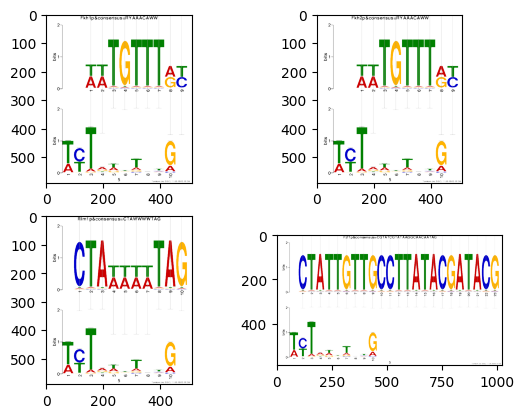

In [ ]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(m3)

# Plot the second image in the second subplot
axs[0, 1].imshow(m4)
axs[1,0].imshow(m5)
axs[1,1].imshow(m6)
# Plot the third image in the third subplot

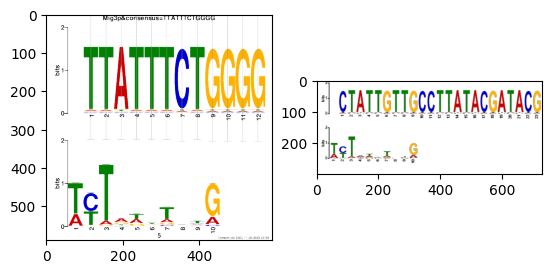

In [ ]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(m1)

# Plot the second image in the second subplot
axs[1].imshow(m7)

In [ ]:
ournuclist = ['TTTGTTTAT', 'TTTGTTTAT', 'CTATTTTTAG', 'CTATTGTTGCCTTATACGATACG', 'TTATTTCTGGGG']
ourtransciptionfactorlist = ['Fkh1p', 'Fkh2p', 'Rlm1p', 'Fzf1p', 'Mig3p or Mig2p', ]

### Compared to motifs by Meme-CHiP

With the original .bed and .narrowPeak files we used the MEME-CHiP algorithims to determine what the motifs would be. These are used by researchers and scientists professionally so they are expected to have a higher level of accuracy. 


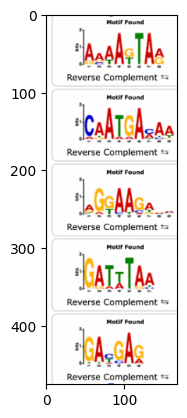

In [ ]:
plt.imshow(OG_motifs)

In [ ]:
memnuclist = ['AAAAGTAA', 'CAATGACAA', 'AGGAAGAAA', 'GATTTAA', 'GACGAG']

- From looking at these motifs it is pretty safe to say there is no similarities between the motifs generated by the Meme-Chip software: https://meme-suite.org/meme/doc/meme-chip.html?man_type=web


and the motifs generated by us and visualized in Tom Tom (a motif visualization software that intakes a MEME file) https://meme-suite.org/meme/info/status?service=TOMTOM&id=appTOMTOM_5.5.216838683678541437346013

- How could this be? We probably shouldn't have trusted our 'super accurate' Quiescent model as much as we did. However, we did test on a bunch of different motif lengths as well as running the actual log data over the model instead of the log model (which got accuracy in the high 90s as well.)

-An observation of note is that the motifs generated by the MEME algorithims are heavily made up of Adenine nucleotides while our generated motifs were mostly made up of Thymine nucleotides. While there were not motifs that were the exact opposite of each other, it is a possible that we are getting the opposite of what we were supposed to based on how we designed our CNN. If we continue to train the data and compare it to the MEME list and still get the opposite of what we were supposed to, that means our problem is with the neural network itself but it still gives us good information as it gives the compliment sequence. 


## Other visualizations

In [ ]:
os.chdir('/content/drive/MyDrive/Rerunningbioproj/Final_project_folder')

In [ ]:
Chrom = Image.open('chrom_pos.png')
motifvis = Image.open('motifs.png')

## Motif Visualizations

- We have 50 convolutional filters, and we extracted the motifs from each filter. 
- Here are the visualizations for each motif. We don't want to go super into depth with this because there are 50 and the entropy scores vary. We grabbed our highest scoring consensus motifs which we will display in the section after this. 
- This is just to get a rough idea of how the motifs look like from each filter and the rough scoring of each nucleotide position within the motifs

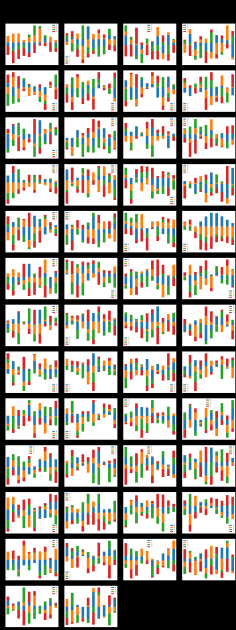

In [ ]:
motifvis.show()

## Amount of occurrences per chromosome

- In the following visualizition we see the amount of times each motif in the above filter motif visualization occurs per chromosome. 
- We observed that chromosome 4, 8, and 12  (according to our data) are where many of the motifs occur the most. 
- The spreads in all the graphs are pretty similar, with very few motifs occuring in chromosomes 1-3 and 5-7
- The graphs seem the same at first, but there are minute differences in each one

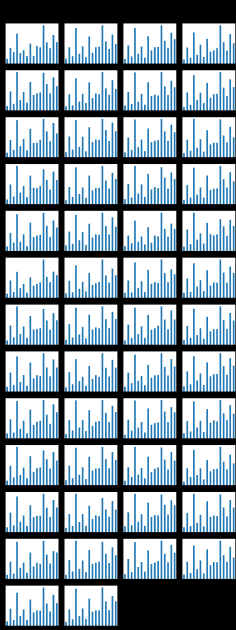

In [ ]:
Chrom.show()

## Domain, IGV analysis

In [ ]:
chrom4plusbound = Image.open('ChrIVboundidentifiers.PNG')

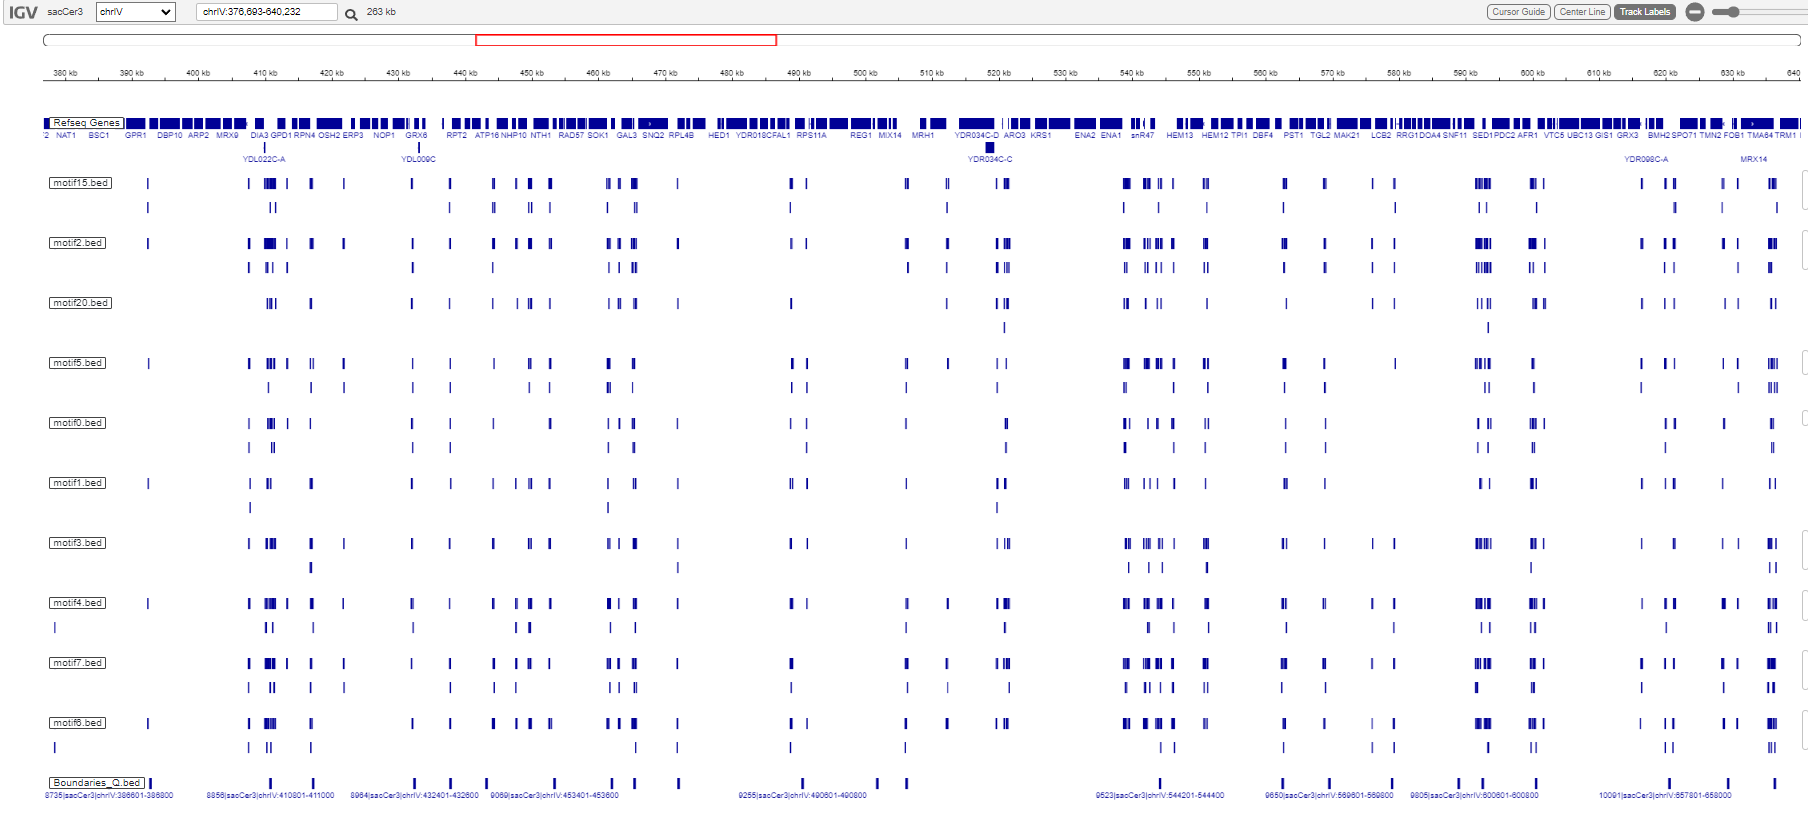

In [ ]:
 chrom4plusbound.show()

- We have a set of .bed files we generated with the motif locations in the genome. With the previous visualization of amount of occurences per genome we observed that Chromosome 4 and 12 had the most motifs. 
- So then we took the domain boundaries in .bed files and compared them to the motif locations we acquired from our own data. 
- We wanted to see whether found sequence domains were related in any way to the motif locations.
- In the chromosomes with the highest occurence of condensin motifs (4 and 12) we found EXTREMLY HIGH relatedness between the domains and the motifs. 
- I am not sure whether this can actually be applied yet, however, most of the domains appear right where we discovered motifs! (This is for our quiescent data and quiescent boundaries)
- This data is also more cleaned up with different motifs from the same dataset because we ran it for longer with different parameters.  

# Part 2

## Visualizations

In [ ]:
!pip install Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
image = Image.open('hm1.png')

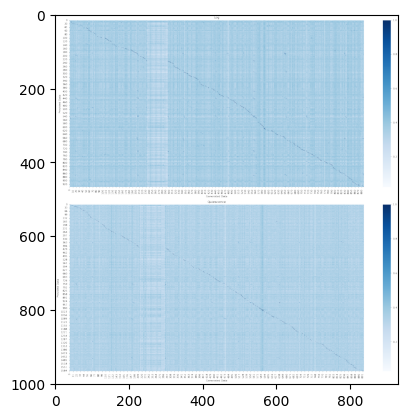

In [ ]:
plt.imshow(image)
plt.show()

### BED file comparisons

- A comparison between Dr. Swygert's and our created .bed files revealed similarities between the data but there were differences as well. 

- Our data revealed more peaks. 
- We used different algorithims to create our .bed files as well as different parameters. 